# Covid19 Estimated Current Cases and Prediction with Ascending Phase Model

Covid19 was first reported in China during December 2019.  On January 23, 2020 China issued lockdown orders for Wuhan and three other cities as the virus spread.  The lockdown was extended on January 24, 2020.  On January 30,2020, the World Health Organization (WHO) declared Covid19 a public health emergency of international concern (PHEIC). On February 25, 2020, Italy put the Lombardy region on lockdown due to Covid19.  One March 9, 2020, Italy expanded the lockdown to include the entire country.  On March 11, 2020, WHO declared Covid19 a global pandemic. Since the first reported case in Dec 2019, approximately three months ago, Covid19 has spread to 167 countries and regions. The United States has started to see widespread cases of Covid19, especially in New York, California and Oregon. Other countries have also been experiencing large numbers of Covid19 infections, specifically Spain, Germany, Iran and France. Many countries have introduced measures to control the virus such as closing schools, promoting social distancing, handwashing, quarantines and lockdowns.  It is likely that these measures have slowed the spread of the virus although there are concerns that it is not enough and that hospitals worldwide are going to overwhelmed with large numbers of Covid19 patients. Most officials seem to agree that the virus is going to keep spreading and that complete containment is not possible at this point. The goal is to slow the spread of the virus so that hospitals aren't overwhelmed with large numbers of Covid19 patients.

This model/analysis has two goals: 

<b>Estimate the number of Covid19 cases each day since the outbreak began:</b>
<br>
Most people agree that the number of Covid19 cases reported isn't the actual number of cases.  The number of cases reported relies on reliable widespread testing and this has only occurred in some regions. Some countries (such as South Korea) instituted widespread drive through testing centers and these countries likely have a better estimate of the spread of the virus. However, other countries have not instituted widespread testing and so the true extent of the spread of the virus is unknown.  The estimated number of cases is calculated using an estimated mortality rate. The reported number of deaths is likely more accurate than the reported number of cases and can give a rough estimate of the actual number of cases. Note that some assumptions goes into the calculation such as the mortality rate and doubling time. The mortality is currently unknown but estimates so far have put it around 1%. It is likely lower because of unreported cases. In some countries it appears to be much higher and so may be variable depending on a patients ability to obtain needed healthcare. The number of deaths is used to calculate the estimated cases by first assuming a certain mortality rate, and time frame that someone dies after contracting Covid19.  For example if the mortality rate is 1% and it takes 25 days for someone to die after they are first exposed, then it is known that 25 days ago 100 people were positive for each reported death. The current number of positive cases can then be estimated based on exponential growth patterns. If 100 people were positive 25 days ago for each reported death, and if the doubling rate is 5 days, then it can be estimated that 3200 people are currently infected for each reported death. 

| Days | Cases|
|------|------|
|   0  | 100  |
|   5  | 200  |
|   10 | 400  |
|   15 | 800  |
|   20 | 1600 |
|   25 | 3200 |


<b>The second goal is to predict the future cases/deaths based on available data</b>.
<br>
Giving an accurate prediction is difficult because the virus is still in the growth phase for most countries and there are still many unknowns.  There are also affects such as social distancing, better personal hygiene, quarantines and lockdowns. Out of these- lockdowns probably have the most drastic affect on total cases, followed by quarantines, followed by social distancing and better personl hygiene.  I used the following concentration based model to predict the number of cases and deaths during the growth phase of the virus. This model is only good for the growth phase but could easily be adjusted to model the entire phase of the outbreak as a "modified SIR" model. I decided not to use the SIR model for this because we are still very early in this pandemic and I thought this model "might" be more accurate for modeling early growth since it required less assumptions.  This model would not be accurate formodeling late growth such as what is being seen in China and South Korea right now. This model can be adjusted for the affects of social distancing, quarantining etc by adding a factor to the equation that describes this affect. <b>I'm planning to add this factor after looking at the modeling results. </b>
The model used to describe the data calculates the change in cases, deaths etc with time using the following equation: 

$\frac{dC_A}{dt} = k C_A^{\alpha}$

There have been many papers and early estimates of the models parameters published either in journals or online such as the mortality rate, doubling rate, $R_o$, time from infection to becoming symptomatic, and time from displaying first symptoms to death. These parameters vary by country and also in some cases with time. For instance, the mortality rate in Italy has appeared to recently increase. It's unclear if this is because the data is early, there are less positive cases being reported, or if the mortality rate has actually increased. Some countries have extremely low mortality rates while others have higher mortality rates. Other parameters such as the growth factor have been difficult to estimate for many countries because data is still sparse.  It is likely that in a few weeks the growth factor will become more clear in many countries/regions. The growth factor is important because if it is calculated as a function of time it is possible to tell when the virus is on the decline. So if the growth factor is greater than one the virus is still increasing, if it is equal to one it has stabalized and if it is less than one it is declining (upper portion of logistic curve).  All current data suggests that most countries currently have a growth factor greater than one with the exception of China and South Korea. The parameters used in the model are estimated from available data and/or taken from available literature that is becoming more prevalent everyday. 

Keep in mind that many assumptions go into this model and that the "estimated" and "predicted" results are just one scenario. This virus is spreading quickly and as a result data, parameters, and models are evolving daily. 

Thank you to John Hopkins University for making the data set public.  

## Import Modules for model

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import datetime as dt
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium #to create maps


from sklearn.linear_model import LinearRegression
from sklearn import metrics

#for nonlinear regression
from scipy.optimize import curve_fit



Load file with function definitions

In [2]:
#%%writefile covid19_ascending_model_functions.py

# %load covid19_ascending_model_functions.py
"""
Created on Thu Mar 26 14:18:40 2020

@author: Raili
"""

#Date is transformed into a column. This makes plotting the time series data easeier. 

def add_date_column(df_raw):
    df_date_column = df_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_name='Cases', var_name='Date')
    df_date_column = df_date_column.set_index(['Country/Region', 'Province/State', 'Date'])
    return df_date_column

#function that takes raw data for confirmed, deaths and recovered. Returns dataframe with 
#current accumulated data for confirmed, deaths and recovered.  Basically, it removes
#dates and returns totals for each country at the most recently reported data (last column)

#example function call
#accum_data_df = accum_data(raw_data_confirmed, raw_data_recovered, raw_data_deaths)
#raw_data_confirmed (and others) have following header:
#Province/State, Country/Region, Lat, Long, 1/22/20,...3/18/20

#Dataframe that is returned has following header:
#Province/State, Country, Lat, Long, Total Confirmed, Total Deaths, Total Recovered
def accumulated_data(confirmed, deaths, recovered):
        
    accum_data_df = confirmed[['Province/State', 'Country/Region', 'Lat', 'Long']]
    
    accum_data_df['Total Confirmed'] = confirmed.iloc[ :, -1]
    accum_data_df['Total Deaths'] = deaths.iloc[ :, -1]
    accum_data_df['Total Recovered'] = recovered.iloc[ :, -1]

    return accum_data_df


### Get DailyData from Cumulative sum
def daily_data(country_time_df,old_name,new_name):
    accum_country_daily=country_time_df.groupby(level=0).diff().fillna(0)
    accum_country_daily=accum_country_daily.rename(columns={old_name:new_name})
    return accum_country_daily

#Function that takes data with date column and returns a dataframe with countries, dates, confirmed, deaths and recovered.
#type_data is either Country/Region or Province/State. 
#Example function call: 
#timeseries_country_data(confirmed_date_column,'Cases','Total Confirmed Cases', 'Country')
#confirmed_date_column has following header:
#Country/Region, Province/State, Date, Lat, Long, Cases

#Dateframe that is returned has following header:
#Country/Region, Date, ......, newname

def timeseries_data(_time_df,old_name,new_name, type_data):
        
    timeseries_df=_time_df.groupby([type_data,'Date'])['Cases'].sum().reset_index()
    timeseries_df=timeseries_df.set_index([type_data,'Date'])
    timeseries_df.index=timeseries_df.index.set_levels([timeseries_df.index.levels[0], pd.to_datetime(timeseries_df.index.levels[1])])
    timeseries_df=timeseries_df.sort_values([type_data,'Date'],ascending=True)
    timeseries_df=timeseries_df.rename(columns={old_name:new_name})
    return timeseries_df

#Function that takes data with date column and returns a dataframe with states, dates, confirmed, deaths and recovered. 
#Example function call: 
#timeseries_state_data(confirmed_date_column, country, 'Cases','Total Confirmed Cases')
#country is the country that you want state data
#confirmed_date_column has following header:
#Country/Region, Province/State, Date, Lat, Long, Cases

#Dateframe that is returned has following header:
#State, Date, ......, newname

def timeseries_state_data(state_time_df,old_name,new_name):
    state_time_df=state_time_df.groupby(['Province/State','Date'])['Cases'].sum().reset_index()
    state_time_df=state_time_df.set_index(['Province/State','Date'])
    state_time_df.index=state_time_df.index.set_levels([state_time_df.index.levels[0], pd.to_datetime(state_time_df.index.levels[1])])
    state_time_df=state_time_df.sort_values(['Province/State','Date'],ascending=True)
    state_time_df=state_time_df.rename(columns={old_name:new_name})
    
    return state_time_df

#function to clean the data
def clean_data(df_to_clean):
    
    # replace mainland china with China
    df_to_clean['Country/Region'] = df_to_clean['Country/Region'].replace('Mainland China', 'China')
    
    return df_to_clean
    
    
#-----------------------------------------------------------------------------------------------------------------
#function calculates likely positive cases based on current death rate, mortality rate, and doubling time
#consolidated_df: dataframe that includes columns named 'Daily New Deaths'

def estimate_current_cases(consolidated_df, days_to_symptoms, days_after_symptoms, mortality_rate, doubling_time, place):
    
    death_time = days_to_symptoms + days_after_symptoms

    #calculate estimated people who have virus at the time of the death. For instance if death_time is 
    #20 days this calculation shows the possible number of positive cases 20 days previously.
    #Since these are calculated for the number of days before death shift data in dataframe back by death_time
    #days.
    estimated_past_cases = consolidated_df.copy()
    estimated_past_cases = estimated_past_cases.loc[:,['Daily New Deaths']]
    estimated_past_cases = np.round(estimated_past_cases['Daily New Deaths']/mortality_rate,3)

    #calculate possible number of cases at current date with the doubling rate. 
    #estimated_current_cases = consolidated_df.copy()
    #estimated_current_cases = estimated_current_cases.loc[:,['Daily New Deaths']]
    estimated_current_cases = np.round(estimated_past_cases*2**(death_time/doubling_time))

    #Estimated past cases were calculated for the number of days death_time previously. They need to be shifted back
    #by this number of days. 
    estimated_past_cases = estimated_past_cases.groupby([place]).shift(-death_time)

    #Combine estimated past cases with estimated current cases
    data_to_combine = [estimated_past_cases, estimated_current_cases]
    headers = ['Estimated Past Cases', 'Estimated Current Cases']
    estimated_cases = pd.concat(data_to_combine, axis=1, keys=headers)
    
    return estimated_cases


## Import data John Hopkins Data

In [3]:
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

raw_data_confirmed = pd.read_csv(url_confirmed)
raw_data_deaths = pd.read_csv(url_deaths)
raw_data_recovered = pd.read_csv(url_recovered)

raw_data_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,998,1004,1029,1050,1076,1099,1122,1137,1143,1164
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,762,763,763,763,763,764,764,764,765,844
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,69,70,70,71,74,81,84,86,86,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,251,299,441,443,458,463,479,483,484,484
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,222,233,249,256,278,283,310,323,354,399
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,87,87,87,87,87,87,106,106,106,132
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,2929,3100,3266,3424,3563,3686,3807,3930,4013,4100


## Import State Data from Soothsayer

In [4]:
url_confirmed_state = 'https://www.soothsawyer.com/wp-content/uploads/2020/03/time_series_19-covid-Confirmed.csv'
url_deaths_state = 'https://www.soothsawyer.com/wp-content/uploads/2020/03/time_series_19-covid-Deaths.csv'
url_recovered_state = 'https://www.soothsawyer.com/wp-content/uploads/2020/03/time_series_19-covid-Recovered.csv'

raw_data_cases_state = pd.read_csv(url_confirmed_state)
raw_data_deaths_state = pd.read_csv(url_deaths_state)
raw_data_recovered_state = pd.read_csv(url_recovered_state)



In [5]:
raw_data_cases_state

,Country/Region,Province/State,Long,Lat,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,5/24/2020,5/25/2020,5/26/2020,5/27/2020,5/28/2020,5/29/2020,5/30/2020,5/31/2020,6/1/2020,6/2/2020
0,Afghanistan,NaN,65.000000,33.000000,0,0,0,0,0,0,...,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509
1,Albania,NaN,20.168300,41.153300,0,0,0,0,0,0,...,998,1004,1029,1050,1076,1099,1122,1137,1143,1164
2,Algeria,NaN,1.659600,28.033900,0,0,0,0,0,0,...,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626
3,Andorra,NaN,1.521800,42.506300,0,0,0,0,0,0,...,762,763,763,763,763,764,764,764,765,844
4,Angola,NaN,17.873900,-11.202700,0,0,0,0,0,0,...,69,70,70,71,74,81,84,86,86,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,West Bank and Gaza,NaN,35.233200,31.952200,0,0,0,0,0,0,...,423,423,429,434,446,446,447,448,449,451
885,Western Sahara,NaN,-12.885800,24.215500,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
886,Yemen,NaN,48.516388,15.552727,0,0,0,0,0,0,...,222,233,249,256,278,283,310,323,354,399
887,Zambia,NaN,28.283300,-15.416700,0,0,0,0,0,0,...,920,920,920,1057,1057,1057,1057,1057,1089,1089


# Visualize

### Summary Table

In [6]:
#Combine data into a table with accumulated data. This is basically the last column of the 
#raw data set for confirmed cases, recovered cases and deaths. 
accum_data_df = accumulated_data(raw_data_confirmed, raw_data_deaths, raw_data_recovered)
accum_data_df.head()

C:\Users\Raili\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Raili\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Raili\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

,Province/State,Country/Region,Lat,Long,Total Confirmed,Total Deaths,Total Recovered
0,NaN,Afghanistan,33.0000,65.0000,16509,270,1450.0
1,NaN,Albania,41.1533,20.1683,1164,33,891.0
2,NaN,Algeria,28.0339,1.6596,9626,667,6067.0
3,NaN,Andorra,42.5063,1.5218,844,51,733.0
4,NaN,Angola,-11.2027,17.8739,86,4,18.0


In [7]:
country_table = accum_data_df.groupby('Country/Region')['Total Confirmed','Total Deaths', 'Total Recovered'].sum()
country_table_sorted = country_table.sort_values(by='Total Confirmed', ascending=False)
country_table_sorted.style.background_gradient()

,Total Confirmed,Total Deaths,Total Recovered
Country/Region,,,
US,1831821,106180,463868
Brazil,555383,31199,1910
Russia,423186,5031,18
United Kingdom,279392,39452,1300
Spain,239932,27127,1625
Italy,233515,33530,10467
India,207191,5829,160092
France,188450,28943,239762
Germany,183879,8563,24


### Map Showing Confirmed Cases

In [8]:
#Remove cases from dataset that are zero for 'Total Confirmed' for map
map_data = accum_data_df[accum_data_df['Total Confirmed']>0]

#map of Total Confirmed Cases
covid_map = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=6, zoom_start=2)

for i in range(0, len(map_data)):
    folium.CircleMarker(
        location=[map_data.iloc[i]['Lat'], map_data.iloc[i]['Long']],
        radius=int(map_data.iloc[i]['Total Confirmed'])/5000,
        color='blue',
        tooltip =   '<li><bold>Country : '+str(map_data.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(map_data.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(map_data.iloc[i]['Total Confirmed'])+
                    '<li><bold>Deaths : '+str(map_data.iloc[i]['Total Deaths'])
         ).add_to(covid_map)
    
covid_map


### Map Showing Confirmed Deaths

In [9]:
#Remove cases from dataset that are zero for 'Total Deaths' for map
map_data_deaths = map_data[map_data['Total Deaths']>0]

#map of Total Confirmed Deaths
covid_map_deaths = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=6, zoom_start=2)

for i in range(0, len(map_data_deaths)):
    folium.CircleMarker(
        location=[map_data_deaths.iloc[i]['Lat'], map_data_deaths.iloc[i]['Long']],
        radius=int(map_data_deaths.iloc[i]['Total Deaths'])/1000,
        color='black',
        tooltip =   '<li><bold>Deaths : '+str(map_data_deaths.iloc[i]['Total Deaths'])).add_to(covid_map_deaths)      
        
covid_map_deaths

In [10]:
#Remove cases from dataset that are zero for 'Total Deaths' for map
map_data_deaths = map_data[map_data['Total Deaths']>0]


## Plot Timeseries Data and Estimate Number of Likely Cases from Death Data

### Plot Data for Countries

In [11]:
#Convert dates from raw data from column headers to a column for easier plotting. 
#Do this for the confirmed, deaths and recovered data sets. 
confirmed_date_column=add_date_column(raw_data_confirmed)
deaths_date_column=add_date_column(raw_data_deaths)
#recovered_date_column=add_date_column(raw_data_recovered)

confirmed_date_column.head()

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Afghanistan,NaN,1/22/20,33.0000,65.0000,0
Albania,NaN,1/22/20,41.1533,20.1683,0
Algeria,NaN,1/22/20,28.0339,1.6596,0
Andorra,NaN,1/22/20,42.5063,1.5218,0
Angola,NaN,1/22/20,-11.2027,17.8739,0


In [12]:
#Consolidate dates associated with each country for confirmed, deaths and recovered
confirmed_country_df=timeseries_data(confirmed_date_column,'Cases','Total Confirmed Cases', 'Country/Region')
deaths_country_df=timeseries_data(deaths_date_column,'Cases','Total Deaths','Country/Region')
#recoveries_country_df=timeseries_data(recovered_date_column,'Cases','Total Recoveries','Country/Region')

confirmed_country_df.head()

Total Confirmed Cases
Country/Region Date                             
Afghanistan    2020-01-22                      0
               2020-01-23                      0
               2020-01-24                      0
               2020-01-25                      0
               2020-01-26                      0

In [13]:
#Calculate daily data for confirmed, deaths and recoveries. This is the difference of data between
#each successive day. 
new_daily_cases_country=daily_data(confirmed_country_df,'Total Confirmed Cases','Daily New Cases')
new_daily_deaths_country=daily_data(deaths_country_df,'Total Deaths','Daily New Deaths')
#new_daily_recoveries_country=daily_data(recoveries_country_df,'Total Recoveries','Daily New Recoveries')

new_daily_cases_country.head()

Daily New Cases
Country/Region Date                       
Afghanistan    2020-01-22              0.0
               2020-01-23              0.0
               2020-01-24              0.0
               2020-01-25              0.0
               2020-01-26              0.0

In [14]:
#Combine the date, country and daily values for confirmed, deaths and recovered into one dataframe. 
country_consolidated_df=pd.merge(confirmed_country_df,deaths_country_df,how='left',left_index=True,right_index=True)
#country_consolidated_df=pd.merge(country_consolidated_df,recoveries_country_df,how='left',left_index=True,right_index=True)
country_consolidated_df=pd.merge(country_consolidated_df,new_daily_cases_country,how='left',left_index=True,right_index=True)
country_consolidated_df=pd.merge(country_consolidated_df,new_daily_deaths_country,how='left',left_index=True,right_index=True)
#country_consolidated_df=pd.merge(country_consolidated_df,new_daily_recoveries_country,how='left',left_index=True,right_index=True)

#Calculate current active cases and add as new column in dataframe
#country_consolidated_df['Active Cases']=country_consolidated_df['Total Confirmed Cases']-country_consolidated_df['Total Deaths']

#Calculate percent recoveries
#country_consolidated_df['Share of Recoveries - Closed Cases']=np.round(country_consolidated_df['Total Recoveries']/(country_consolidated_df['Total Recoveries']+country_consolidated_df['Total Deaths']),2)

#Calculate mortality rate by using total deaths divided total confirmed cases. Note that this mortality rate
#is likely higher than the actual mortality rate because there are cases that aren't counted if the person wasn't
#tested. Also, this is only one way to calculate the mortality rate. There are also people among the total confirmed
#cases who have not yet died or recovered. This number should be considered a best guessed estimate based on 
#available data. 
country_consolidated_df['Death to Cases Ratio']=np.round(country_consolidated_df['Total Deaths']/country_consolidated_df['Total Confirmed Cases'],3)

country_consolidated_df.head()

Total Confirmed Cases  Total Deaths  \
Country/Region Date                                              
Afghanistan    2020-01-22                      0             0   
               2020-01-23                      0             0   
               2020-01-24                      0             0   
               2020-01-25                      0             0   
               2020-01-26                      0             0   

                           Daily New Cases  Daily New Deaths  \
Country/Region Date                                            
Afghanistan    2020-01-22              0.0               0.0   
               2020-01-23              0.0               0.0   
               2020-01-24              0.0               0.0   
               2020-01-25              0.0               0.0   
               2020-01-26              0.0               0.0   

                           Death to Cases Ratio  
Country/Region Date                              
Afghanistan    2020-01-22                   NaN  
               2020-01-23                   NaN  
               2020-01-24                   NaN  
               2020-01-25                   NaN  
               2020-01-26                   NaN

This part of the model is going to estimate the possible number of cases based on death rate data. Since the number of cases reported is actually low because it only includes cases that have been tested this estimate based on death data may give a more accurate representation of how widespread the virus is. This will also be used to help predict future case numbers and deaths.  

In [15]:
#Estimated parameters
#The incubation period (time from exposure to the development of symptoms) of the virus is estimated to be between 2 and 14 days based on the following sources:
#
#    The World Health Organization (WHO) reported an incubation period for COVID-19 between 2 and 10 days. [1]
#    China’s National Health Commission (NHC) had initially estimated an incubation period from 10 to 14 days [2].
#    The United States' CDC estimates the incubation period for COVID-19 to be between 2 and 14 days [3].
#    DXY.cn, a leading Chinese online community for physicians and health care professionals, is reporting an incubation period of "3 to 7 days, up to 14 days".
#
#The estimated range will be most likely narrowed down as more data becomes available.
days_to_symptoms = 6 #number of days until someone who was exposed shows symptoms

#Average person dies within 14 days after onset of symptoms
#https://onlinelibrary.wiley.com/doi/pdf/10.1002/jmv.25689
days_after_symptoms = 14 #number of days after someone who shows symptoms dies

#time to death is time from exposure that symptoms first appeared, and then time to death 
#after symptoms
death_time = days_to_symptoms + days_after_symptoms

#Current worldwide average is around 1%, however it was higher in China (3.4%) and other countries. 
#Since testing is still not widespread in many places it's hard to know what the true mortality rate is 
#at this point. 
mortality_rate = 0.01 #percent

#There are also various estimates for the doubling rate. The data from the US and Italy indicates that the 
#doubling time is approximately 5 days. 
doubling_time = 3 #days for cases to double

estimated_cases = estimate_current_cases(country_consolidated_df, days_to_symptoms, days_after_symptoms, mortality_rate, doubling_time, 'Country/Region')


In [16]:
#Add estimated cases to country_consolidated_df
country_consolidated_df = pd.merge(country_consolidated_df, estimated_cases, how='left', left_index=True, right_index=True)

#pd.set_option('display.max_rows', 12000)
#country_consolidated_df

In [17]:
#Place is an array containing a list of countries or a list of states
#df is a dataframe containing the following columns: Total Confirmed Cases, Total Deaths, Death to Case Ratio, 
#estimated_current_cases, estimated_past_cases

def plot_country_data(Country):
    fig = make_subplots(rows=6, cols=1,shared_xaxes=False, 
                    subplot_titles=('Daily Confirmed Cases', 'Accumulative Confirmed Cases', 'Daily Deaths', 'Accumulative Deaths', 'Estimated Mortality Rate', 'Estimated Current Cases'))
    fig.add_trace(go.Bar(x=country_consolidated_df.loc[Country].index,y=country_consolidated_df.loc[Country, 'Daily New Cases'],
                    name='Daily Confirmed Cases'),
                    row=1, col=1)
    fig.add_trace(go.Scatter(x=country_consolidated_df.loc[Country].index,y=country_consolidated_df.loc[Country, 'Total Confirmed Cases'],
                    name='Accumulative Confirmed Cases',
                    line=dict(color='firebrick', width=3, dash='dot')),
                    row=2, col=1)
    fig.add_trace(go.Bar(x=country_consolidated_df.loc[Country].index,y=country_consolidated_df.loc[Country,'Daily New Deaths'],
                    name='Daily Deaths'),
                    row=3, col=1)
    fig.add_trace(go.Scatter(x=country_consolidated_df.loc[Country].index,y=country_consolidated_df.loc[Country,'Total Deaths'],
                    name='Acculative Deaths',
                    line=dict(color='firebrick', width=3, dash='dot')),
                    row=4, col=1)
    fig.add_trace(go.Scatter(x=country_consolidated_df.loc[Country].index,y=country_consolidated_df.loc[Country,'Death to Cases Ratio'],
                    mode='lines+markers',
                    name='Estimated Mortality Rate',
                    line=dict(color='LightSkyBlue',width=2)),
                    row=5,col=1)
    fig.add_trace(go.Bar(x=country_consolidated_df.loc[Country].index,y=country_consolidated_df.loc[Country,'Estimated Current Cases'],
                    name='Estimated Current Cases'),
                    row=6,col=1)
    fig.append_trace(go.Bar(x=country_consolidated_df.loc[Country].index,y=country_consolidated_df.loc[Country,'Estimated Past Cases'],
                    name='Estimated Current Cases'),
                    row=6,col=1)
    
    fig.update_layout(height=1200, width=800,showlegend=False)
    return fig

In [18]:
#Plot country data.  

CountriesList=['US','Italy','Spain','Germany','Iran','China','France','Switzerland', 'Canada','United Kingdom','Netherlands','Austria','Belgium','Norway','Sweden','Korea, South']
interact(plot_country_data, Country=widgets.Dropdown(options=CountriesList))

interactive(children=(Dropdown(description='Country', options=('US', 'Italy', 'Spain', 'Germany', 'Iran', 'Chi…

<function __main__.plot_country_data(Country)>

In [19]:
mean_death_to_cases_ratio = country_consolidated_df.groupby('Country/Region', as_index=True)['Death to Cases Ratio'].agg([np.mean])
mean_death_to_cases_ratio = mean_death_to_cases_ratio.dropna()
mean_death_to_cases_ratio = mean_death_to_cases_ratio[mean_death_to_cases_ratio['mean']>0]
mean_death_to_cases_ratio = mean_death_to_cases_ratio[mean_death_to_cases_ratio['mean']<0.08]

In [20]:
#Table showing mortality rate for each state or province
temp = mean_death_to_cases_ratio
temp_sorted = temp.sort_values(by=['mean'], ascending=False)
temp_sorted.style.background_gradient()

,mean
Country/Region,
Angola,0.0796933
Belgium,0.0793917
Hungary,0.0792088
Iran,0.0785619
San Marino,0.0744742
Suriname,0.0706667
Malawi,0.0685323
Botswana,0.0681846
Spain,0.0674309


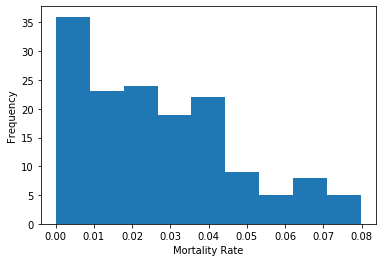

In [21]:
histogram_x = mean_death_to_cases_ratio['mean']
plt.hist(histogram_x, bins='auto')
plt.xlabel('Mortality Rate')
plt.ylabel('Frequency')
plt.show()

In [22]:
mean_death_to_cases_ratio.mean()

mean    0.02726
dtype: float64

### Plot Data for States

In [23]:
#Convert dates from raw data from column headers to a column for easier plotting. 
#Do this for the confirmed, deaths and recovered data sets. 
confirmed_date_column_state = add_date_column(raw_data_cases_state)
deaths_date_column_state = add_date_column(raw_data_deaths_state)
recovered_date_column_state = add_date_column(raw_data_recovered_state)

confirmed_date_column_state.head()

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Afghanistan,NaN,1/22/2020,33.0000,65.0000,0
Albania,NaN,1/22/2020,41.1533,20.1683,0
Algeria,NaN,1/22/2020,28.0339,1.6596,0
Andorra,NaN,1/22/2020,42.5063,1.5218,0
Angola,NaN,1/22/2020,-11.2027,17.8739,0


In [24]:
#consolidate state data for timeseries plots

confirmed_state_df=timeseries_data(confirmed_date_column_state,'Cases','Total Confirmed Cases','Province/State')
deaths_state_df=timeseries_data(deaths_date_column_state,'Cases','Total Deaths','Province/State')
recoveries_state_df=timeseries_data(recovered_date_column_state,'Cases','Total Recoveries','Province/State')

confirmed_state_df.head()

Total Confirmed Cases
Province/State Date                             
Abruzzo        2020-01-22                      0
               2020-01-23                      0
               2020-01-24                      0
               2020-01-25                      0
               2020-01-26                      0

In [25]:
#get new daily data from cumulative sum
current_cases_state=daily_data(confirmed_state_df,'Total Confirmed Cases','Daily New Cases')
current_deaths_state=daily_data(deaths_state_df,'Total Deaths','Daily New Deaths')
current_recoveries_state=daily_data(recoveries_state_df,'Total Recoveries','Daily New Recoveries')



In [26]:
confirmed_state_df

Total Confirmed Cases
Province/State  Date                             
Abruzzo         2020-01-22                      0
                2020-01-23                      0
                2020-01-24                      0
                2020-01-25                      0
                2020-01-26                      0
...                                           ...
Zhytomyr Oblast 2020-05-29                      0
                2020-05-30                      0
                2020-05-31                      0
                2020-06-01                    742
                2020-06-02                    776

[90706 rows x 1 columns]

In [27]:
#combine all data sets
state_consolidated_df=pd.merge(confirmed_state_df,deaths_state_df,how='left',left_index=True,right_index=True)
state_consolidated_df=pd.merge(state_consolidated_df,recoveries_state_df,how='left',left_index=True,right_index=True)
state_consolidated_df=pd.merge(state_consolidated_df,current_cases_state,how='left',left_index=True,right_index=True)
state_consolidated_df=pd.merge(state_consolidated_df,current_deaths_state,how='left',left_index=True,right_index=True)
state_consolidated_df=pd.merge(state_consolidated_df,current_recoveries_state,how='left',left_index=True,right_index=True)
state_consolidated_df['Active Cases']=state_consolidated_df['Total Confirmed Cases']-state_consolidated_df['Total Deaths']-state_consolidated_df['Total Recoveries']
state_consolidated_df['Share of Recoveries - Closed Cases']=np.round(state_consolidated_df['Total Recoveries']/(state_consolidated_df['Total Recoveries']+state_consolidated_df['Total Deaths']),2)
state_consolidated_df['Death to Cases Ratio']=np.round(state_consolidated_df['Total Deaths']/state_consolidated_df['Total Confirmed Cases'],3)


In [28]:

estimated_cases_state = estimate_current_cases(state_consolidated_df, days_to_symptoms, days_after_symptoms, mortality_rate, doubling_time,'Province/State')


In [29]:
#Add estimated cases to country_consolidated_df
state_consolidated_df = pd.merge(state_consolidated_df, estimated_cases_state, how='left', left_index=True, right_index=True)
state_consolidated_df

Total Confirmed Cases  Total Deaths  \
Province/State  Date                                              
Abruzzo         2020-01-22                      0             0   
                2020-01-23                      0             0   
                2020-01-24                      0             0   
                2020-01-25                      0             0   
                2020-01-26                      0             0   
...                                           ...           ...   
Zhytomyr Oblast 2020-05-29                      0             0   
                2020-05-30                      0             0   
                2020-05-31                      0             0   
                2020-06-01                    742            14   
                2020-06-02                    776            14   

                            Total Recoveries  Daily New Cases  \
Province/State  Date                                            
Abruzzo         2020-01-22                 0              0.0   
                2020-01-23                 0              0.0   
                2020-01-24                 0              0.0   
                2020-01-25                 0              0.0   
                2020-01-26                 0              0.0   
...                                      ...              ...   
Zhytomyr Oblast 2020-05-29                 0              0.0   
                2020-05-30                 0              0.0   
                2020-05-31                 0              0.0   
                2020-06-01               416            742.0   
                2020-06-02               443             34.0   

                            Daily New Deaths  Daily New Recoveries  \
Province/State  Date                                                 
Abruzzo         2020-01-22               0.0                   0.0   
                2020-01-23               0.0                   0.0   
                2020-01-24               0.0                   0.0   
                2020-01-25               0.0                   0.0   
                2020-01-26               0.0                   0.0   
...                                      ...                   ...   
Zhytomyr Oblast 2020-05-29               0.0                   0.0   
                2020-05-30               0.0                   0.0   
                2020-05-31               0.0                   0.0   
                2020-06-01              14.0                 416.0   
                2020-06-02               0.0                  27.0   

                            Active Cases  Share of Recoveries - Closed Cases  \
Province/State  Date                                                           
Abruzzo         2020-01-22             0                                 NaN   
                2020-01-23             0                                 NaN   
                2020-01-24             0                                 NaN   
                2020-01-25             0                                 NaN   
                2020-01-26             0                                 NaN   
...                                  ...                                 ...   
Zhytomyr Oblast 2020-05-29             0                                 NaN   
                2020-05-30             0                                 NaN   
                2020-05-31             0                                 NaN   
                2020-06-01           312                                0.97   
                2020-06-02           319                                0.97   

                            Death to Cases Ratio  Estimated Past Cases  \
Province/State  Date                                                     
Abruzzo         2020-01-22                   NaN                   0.0   
                2020-01-23                   NaN                   0.0   
                2020-01-24                   NaN              

In [30]:
state_consolidated_df

Total Confirmed Cases  Total Deaths  \
Province/State  Date                                              
Abruzzo         2020-01-22                      0             0   
                2020-01-23                      0             0   
                2020-01-24                      0             0   
                2020-01-25                      0             0   
                2020-01-26                      0             0   
...                                           ...           ...   
Zhytomyr Oblast 2020-05-29                      0             0   
                2020-05-30                      0             0   
                2020-05-31                      0             0   
                2020-06-01                    742            14   
                2020-06-02                    776            14   

                            Total Recoveries  Daily New Cases  \
Province/State  Date                                            
Abruzzo         2020-01-22                 0              0.0   
                2020-01-23                 0              0.0   
                2020-01-24                 0              0.0   
                2020-01-25                 0              0.0   
                2020-01-26                 0              0.0   
...                                      ...              ...   
Zhytomyr Oblast 2020-05-29                 0              0.0   
                2020-05-30                 0              0.0   
                2020-05-31                 0              0.0   
                2020-06-01               416            742.0   
                2020-06-02               443             34.0   

                            Daily New Deaths  Daily New Recoveries  \
Province/State  Date                                                 
Abruzzo         2020-01-22               0.0                   0.0   
                2020-01-23               0.0                   0.0   
                2020-01-24               0.0                   0.0   
                2020-01-25               0.0                   0.0   
                2020-01-26               0.0                   0.0   
...                                      ...                   ...   
Zhytomyr Oblast 2020-05-29               0.0                   0.0   
                2020-05-30               0.0                   0.0   
                2020-05-31               0.0                   0.0   
                2020-06-01              14.0                 416.0   
                2020-06-02               0.0                  27.0   

                            Active Cases  Share of Recoveries - Closed Cases  \
Province/State  Date                                                           
Abruzzo         2020-01-22             0                                 NaN   
                2020-01-23             0                                 NaN   
                2020-01-24             0                                 NaN   
                2020-01-25             0                                 NaN   
                2020-01-26             0                                 NaN   
...                                  ...                                 ...   
Zhytomyr Oblast 2020-05-29             0                                 NaN   
                2020-05-30             0                                 NaN   
                2020-05-31             0                                 NaN   
                2020-06-01           312                                0.97   
                2020-06-02           319                                0.97   

                            Death to Cases Ratio  Estimated Past Cases  \
Province/State  Date                                                     
Abruzzo         2020-01-22                   NaN                   0.0   
                2020-01-23                   NaN                   0.0   
                2020-01-24                   NaN              

In [31]:
def plot_state_data(State):
    fig = make_subplots(rows=6, cols=1,shared_xaxes=False, 
                    subplot_titles=('Daily Confirmed Cases', 'Accumulative Confirmed Cases', 'Daily Deaths', 'Accumulative Deaths', 'Estimated Mortality Rate', 'Estimated Current Cases'))
    fig.add_trace(go.Bar(x=state_consolidated_df.loc[State].index,y=state_consolidated_df.loc[State, 'Daily New Cases'],
                    name='Daily Confirmed Cases'),
                    row=1, col=1)
    fig.add_trace(go.Scatter(x=state_consolidated_df.loc[State].index,y=state_consolidated_df.loc[State, 'Total Confirmed Cases'],
                    name='Accumulative Confirmed Cases',
                    line=dict(color='firebrick', width=3, dash='dot')),
                    row=2, col=1)
    fig.add_trace(go.Bar(x=state_consolidated_df.loc[State].index,y=state_consolidated_df.loc[State,'Daily New Deaths'],
                    name='Daily Deaths'),
                    row=3, col=1)
    fig.add_trace(go.Scatter(x=state_consolidated_df.loc[State].index,y=state_consolidated_df.loc[State,'Total Deaths'],
                    name='Acculative Deaths',
                    line=dict(color='firebrick', width=3, dash='dot')),
                    row=4, col=1)
    fig.add_trace(go.Scatter(x=state_consolidated_df.loc[State].index,y=state_consolidated_df.loc[State,'Death to Cases Ratio'],
                    mode='lines+markers',
                    name='Estimated Mortality Rate',
                    line=dict(color='LightSkyBlue',width=2)),
                    row=5,col=1)
    fig.add_trace(go.Bar(x=state_consolidated_df.loc[State].index,y=state_consolidated_df.loc[State,'Estimated Current Cases'],
                    name='Estimated Current Cases'),
                    row=6,col=1)
    fig.append_trace(go.Bar(x=state_consolidated_df.loc[State].index,y=state_consolidated_df.loc[State,'Estimated Past Cases'],
                    name='Estimated Current Cases'),
                    row=6,col=1)
    
    fig.update_layout(height=1200, width=800,showlegend=False)
    return fig


In [32]:


StateList=['California','Oregon','New York','Texas','Florida','Utah','Wisconsin','Washington','Louisiana','Michigan','South Dakota','North Dakota','Nevada','New Jersey','Colorado','Georgia','Virginia']
interact(plot_state_data, State=widgets.Dropdown(options=StateList))

interactive(children=(Dropdown(description='State', options=('California', 'Oregon', 'New York', 'Texas', 'Flo…

<function __main__.plot_state_data(State)>

In [33]:
mean_death_to_cases_ratio = state_consolidated_df.groupby('Province/State', as_index=True)['Death to Cases Ratio'].agg([np.mean])


In [34]:
mean_death_to_cases_ratio = mean_death_to_cases_ratio.dropna()


In [35]:
mean_death_to_cases_ratio = mean_death_to_cases_ratio[mean_death_to_cases_ratio['mean']>0]
mean_death_to_cases_ratio = mean_death_to_cases_ratio[mean_death_to_cases_ratio['mean']<0.06]

In [36]:
#Table showing mortality rate for each state or province
temp = mean_death_to_cases_ratio
temp_sorted = temp.sort_values(by=['mean'], ascending=False)
temp_sorted.style.background_gradient()

,mean
Province/State,
Hyogo,0.0595
Guadeloupe,0.0592805
Saarland,0.0592
Nuevo Leon,0.0591429
Ibaraki,0.059
Nagasaki,0.059
Tokyo,0.058
Martinique,0.0578194
Baja California Sur,0.0575714


(array([47., 63., 49., 32., 27., 35., 17., 27., 27., 15.]),
 array([0.00033333, 0.00625   , 0.01216667, 0.01808333, 0.024     ,
        0.02991667, 0.03583333, 0.04175   , 0.04766667, 0.05358333,
        0.0595    ]),
 <a list of 10 Patch objects>)

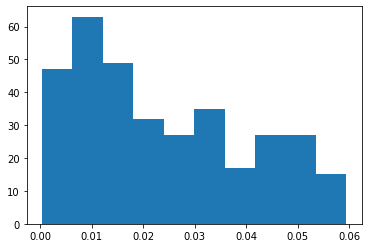

In [37]:
histogram_x = mean_death_to_cases_ratio['mean']
plt.hist(histogram_x, bins='auto')

In [38]:
mean_death_to_cases_ratio.mean()

mean    0.024106
dtype: float64

# Ascending Phase Model

I'm using the following mathematical model for predicting possible outcomes: 

$\frac{dC_A}{dt} = k C_A^{\alpha}$

$C_A$ is the concentration of people who are infected, people who have died or people who have recovered depending on the data. $k$ is the rate constant.  If it is positive that means that there is positive growth.$\alpha$ is the order and can be used to estimate the growth rate. 

This equation can be integrated to get: 

$C_A = ( C_Ao^{1-\alpha}+(1-\alpha) k t)^{\frac{1}{1-\alpha}}$

Defining $m=\frac{1}{1-\alpha}$

The equation can be rewritten as: 

$C_A = (C_Ao^{1/m} + \frac{k}{m} t)^{m}$

Once k and m are known from the regression, $\alpha$ can be calculated from m as: 

$\alpha = 1 - \frac{1}{m}$

Note that this model is only accurate during the growth phase of cases, once the curve flattens and the number of cases declines, this model is no longer accurate. A different type of model is needed once the curve flattens or the number of cases begins to decline. 

In [39]:
#Function for the regression model
def concentration_equation(time, m, k):
    return ( C_ao**(1/m) + (1/m)*k*time)**(m)

#Regression model. Place is either a country or state, examples "US", "New York"
#group is either 'Country/Region' or 'Province/State' 
#col_name is the column that you are running the 
#model on.  For instance "Total Confirmed Cases" or "Total Deaths", df is the dataframe.  This could either be
#the country or the state dataframe. 
#Starting date is a number representing the day at which you want the regression to start. For example, 
#if cases didn't really start occuring until day 30 in a specific area, then this number would be 30. The model
#will cut the dataframe to only includes dates after day 30. 
def regression_model(place, group, col_name, df, starting_date):
    
    #arrange the data into either country or state groups
    group= df.groupby(group)
    group = group.get_group(place)

    #cut the data up to the date that you want to start the regression model. 
    group= group.iloc[starting_date:]

    ydata=group.loc[place, col_name]

    time_data = (group.loc[place].index - group.loc[place].index[0]).days
    
    #reshape the data to 1D arrays for curve_fit
    ydata= ydata.values.reshape(-1, 1)
    time_data=time_data.values.reshape(-1,1)
    
    ydata = ydata.flatten()
    time_data= time_data.flatten()
    
    popt, pcov = curve_fit(concentration_equation, time_data, ydata, maxfev=5000)
    
    return popt

    

In [40]:
#Function that takes into account controls such as social distancing, quarantining, handwashing etc. 

### US Model and Prediction

In [65]:
us_consolidated_cases_df = country_consolidated_df.groupby('Country/Region')
us_consolidated_cases_df = us_consolidated_cases_df.get_group('US')
us_consolidated_cases_df =  us_consolidated_cases_df[(us_consolidated_cases_df.loc['US'].index > '2020-01-22') & (us_consolidated_cases_df.loc['US'].index <= '2020-04-15')]


#date_list = country_consolidated_df.loc['US'].index
pd.set_option('display.max_rows', 100)
us_consolidated_cases_df

Total Confirmed Cases  Total Deaths  \
Country/Region Date                                              
US             2020-01-23                      1             0   
               2020-01-24                      2             0   
               2020-01-25                      2             0   
               2020-01-26                      5             0   
               2020-01-27                      5             0   
               2020-01-28                      5             0   
               2020-01-29                      5             0   
               2020-01-30                      5             0   
               2020-01-31                      7             0   
               2020-02-01                      8             0   
               2020-02-02                      8             0   
               2020-02-03                     11             0   
               2020-02-04                     11             0   
               2020-02-05                     11             0   
               2020-02-06                     11             0   
               2020-02-07                     11             0   
               2020-02-08                     11             0   
               2020-02-09                     11             0   
               2020-02-10                     11             0   
               2020-02-11                     12             0   
               2020-02-12                     12             0   
               2020-02-13                     13             0   
               2020-02-14                     13             0   
               2020-02-15                     13             0   
               2020-02-16                     13             0   
               2020-02-17                     13             0   
               2020-02-18                     13             0   
               2020-02-19                     13             0   
               2020-02-20                     13             0   
               2020-02-21                     15             0   
               2020-02-22                     15             0   
               2020-02-23                     15             0   
               2020-02-24                     51             0   
               2020-02-25                     51             0   
               2020-02-26                     57             0   
               2020-02-27                     58             0   
               2020-02-28                     60             0   
               2020-02-29                     68             1   
               2020-03-01                     74             1   
               2020-03-02                     98             6   
               2020-03-03                    118             7   
               2020-03-04                    149            11   
               2020-03-05                    219            12   
               2020-03-06                    267            14   
               2020-03-07                    403            17   
               2020-03-08                    519            21   
               2020-03-09                    588            22   
               2020-03-10                    962            28   
               2020-03-11                   1285            36   
               2020-03-12                   1667            42   
               2020-03-13                   2181            50   
               2020-03-14                   2729            60   
               2020-03-15                   3536            74   
               2020-03-16                   4661           100   
               2020-03-17                   6437           134   
               2020-03-18                   7781           165   
               2020-03-19                  13748           259   
               2020-03-20                  19274           350   
               2020-03-21                  25600           442   
 

In [66]:

date_list_predicted = pd.date_range(start="2020-01-25", end="2020-05-02")
len(date_list_predicted)

99

C:\Users\Raili\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in power



Text(0.5, 1.0, 'US - Model and Predicted Deaths')

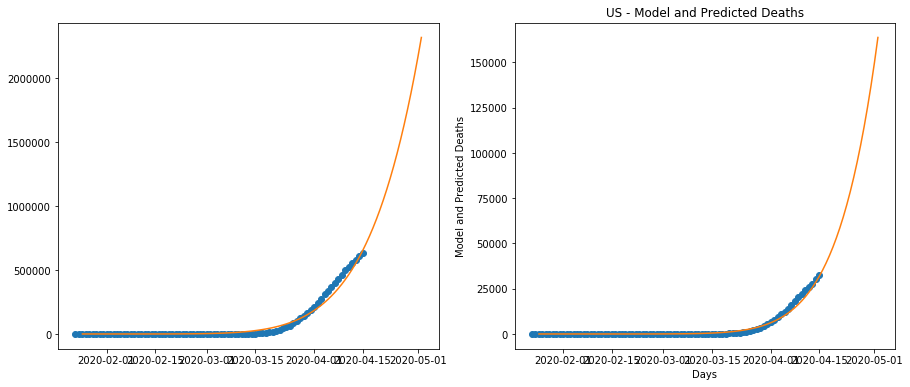

In [67]:
#Model for cases in US
C_ao = 0
US_case_parameters = regression_model('US','Country/Region','Total Confirmed Cases', us_consolidated_cases_df, 0)

#rerun model to predict for dates March 30 - April 29. I'm doing this by running the model for an extra month.
x_time_predict = np.arange(1, len(date_list_predicted)+1, 1)
y_predict_cases_US = concentration_equation(x_time_predict, US_case_parameters[0], US_case_parameters[1])

#Model for deaths in US
US_death_parameters = regression_model('US','Country/Region','Total Deaths', us_consolidated_cases_df, 0)

#rerun model to predict for dates March 30 - April 29. I'm doing this by running the model for an extra month.
x_time_predict = np.arange(1, len(date_list_predicted)+1, 1)
y_predict_deaths_US = concentration_equation(x_time_predict, US_death_parameters[0], US_death_parameters[1])

#Create plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(us_consolidated_cases_df.loc['US'].index, us_consolidated_cases_df['Total Confirmed Cases'],'o')
ax1.plot(date_list_predicted, y_predict_cases_US )
plt.xlabel('Days')
plt.ylabel('Model and Predicted Cases')
plt.title('US - Model and Predicted Cases')

ax2.plot(us_consolidated_cases_df.loc['US'].index, us_consolidated_cases_df['Total Deaths'],'o')
ax2.plot(date_list_predicted, y_predict_deaths_US )         
plt.xlabel('Days')
plt.ylabel('Model and Predicted Deaths')
plt.title('US - Model and Predicted Deaths')         


         

In [44]:
#growth factor: 

alpha = 1 - 1/US_case_parameters[0]
alpha

0.743778936319849

### Italy Model and Predictions

In [68]:
italy_consolidated_cases_df = country_consolidated_df.groupby('Country/Region')
italy_consolidated_cases_df = italy_consolidated_cases_df.get_group('Italy')
italy_consolidated_cases_df =  italy_consolidated_cases_df[(italy_consolidated_cases_df.loc['Italy'].index > '2020-02-20') & (italy_consolidated_cases_df.loc['Italy'].index <= '2020-03-01')]


#date_list = country_consolidated_df.loc['US'].index

italy_consolidated_cases_df

Total Confirmed Cases  Total Deaths  \
Country/Region Date                                              
Italy          2020-02-21                     20             1   
               2020-02-22                     62             2   
               2020-02-23                    155             3   
               2020-02-24                    229             7   
               2020-02-25                    322            10   
               2020-02-26                    453            12   
               2020-02-27                    655            17   
               2020-02-28                    888            21   
               2020-02-29                   1128            29   
               2020-03-01                   1694            34   

                           Daily New Cases  Daily New Deaths  \
Country/Region Date                                            
Italy          2020-02-21             17.0               1.0   
               2020-02-22             42.0               1.0   
               2020-02-23             93.0               1.0   
               2020-02-24             74.0               4.0   
               2020-02-25             93.0               3.0   
               2020-02-26            131.0               2.0   
               2020-02-27            202.0               5.0   
               2020-02-28            233.0               4.0   
               2020-02-29            240.0               8.0   
               2020-03-01            566.0               5.0   

                           Death to Cases Ratio  Estimated Past Cases  \
Country/Region Date                                                     
Italy          2020-02-21                 0.050               18900.0   
               2020-02-22                 0.032               25000.0   
               2020-02-23                 0.019               17500.0   
               2020-02-24                 0.031               36800.0   
               2020-02-25                 0.031               34900.0   
               2020-02-26                 0.026               34500.0   
               2020-02-27                 0.026               47500.0   
               2020-02-28                 0.024               42700.0   
               2020-02-29                 0.026               62700.0   
               2020-03-01                 0.020               79300.0   

                           Estimated Current Cases  
Country/Region Date                                 
Italy          2020-02-21                  10159.0  
               2020-02-22                  10159.0  
               2020-02-23                  10159.0  
               2020-02-24                  40637.0  
               2020-02-25                  30478.0  
               2020-02-26                  20319.0  
               2020-02-27                  50797.0  
               2020-02-28                  40637.0  
               2020-02-29                  81275.0  
               2020-03-01                  50797.0

In [69]:
date_list_predicted = pd.date_range(start="2020-02-23", end="2020-03-15")
len(date_list_predicted)

22

Text(0.5, 1.0, 'Italy - Model and Predicted Deaths')

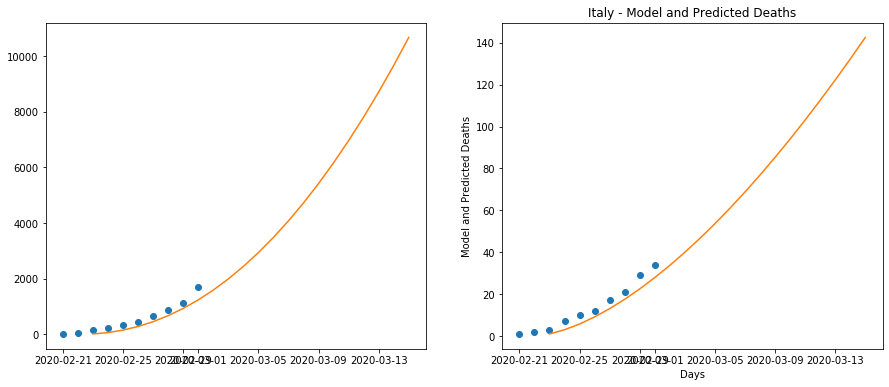

In [70]:
#Model for cases in US
italy_case_parameters = regression_model('Italy','Country/Region','Total Confirmed Cases', italy_consolidated_cases_df, 0)

#rerun model to predict for dates March 30 - April 29. I'm doing this by running the model for an extra month.
x_time_predict = np.arange(1, len(date_list_predicted)+1, 1)
y_predict_cases_italy = concentration_equation(x_time_predict, italy_case_parameters[0], italy_case_parameters[1])

#Model for deaths in US
italy_death_parameters = regression_model('Italy','Country/Region','Total Deaths', italy_consolidated_cases_df, 0)

#rerun model to predict for dates March 30 - April 29. I'm doing this by running the model for an extra month.
x_time_predict = np.arange(1, len(date_list_predicted)+1, 1)
y_predict_deaths_italy = concentration_equation(x_time_predict, italy_death_parameters[0], italy_death_parameters[1])

#Create plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(italy_consolidated_cases_df.loc['Italy'].index, italy_consolidated_cases_df['Total Confirmed Cases'],'o')
ax1.plot(date_list_predicted, y_predict_cases_italy )
plt.xlabel('Days')
plt.ylabel('Model and Predicted Cases')
plt.title('Italy - Model and Predicted Cases')

ax2.plot(italy_consolidated_cases_df.loc['Italy'].index, italy_consolidated_cases_df['Total Deaths'],'o')
ax2.plot(date_list_predicted, y_predict_deaths_italy )         
plt.xlabel('Days')
plt.ylabel('Model and Predicted Deaths')
plt.title('Italy - Model and Predicted Deaths')         



### Spain Model and Predictions

In [71]:
spain_consolidated_cases_df = country_consolidated_df.groupby('Country/Region')
spain_consolidated_cases_df = spain_consolidated_cases_df.get_group('Spain')
spain_consolidated_cases_df =  spain_consolidated_cases_df[(spain_consolidated_cases_df.loc['Spain'].index > '2020-02-20') & (spain_consolidated_cases_df.loc['Spain'].index <= '2020-04-02')]


#date_list = country_consolidated_df.loc['US'].index

spain_consolidated_cases_df

Total Confirmed Cases  Total Deaths  \
Country/Region Date                                              
Spain          2020-02-21                      2             0   
               2020-02-22                      2             0   
               2020-02-23                      2             0   
               2020-02-24                      2             0   
               2020-02-25                      6             0   
               2020-02-26                     13             0   
               2020-02-27                     15             0   
               2020-02-28                     32             0   
               2020-02-29                     45             0   
               2020-03-01                     84             0   
               2020-03-02                    120             0   
               2020-03-03                    165             1   
               2020-03-04                    222             2   
               2020-03-05                    259             3   
               2020-03-06                    400             5   
               2020-03-07                    500            10   
               2020-03-08                    673            17   
               2020-03-09                   1073            28   
               2020-03-10                   1695            35   
               2020-03-11                   2277            54   
               2020-03-12                   2277            55   
               2020-03-13                   5232           133   
               2020-03-14                   6391           195   
               2020-03-15                   7798           289   
               2020-03-16                   9942           342   
               2020-03-17                  11748           533   
               2020-03-18                  13910           623   
               2020-03-19                  17963           830   
               2020-03-20                  20410          1043   
               2020-03-21                  25374          1375   
               2020-03-22                  28768          1772   
               2020-03-23                  35136          2311   
               2020-03-24                  39885          2808   
               2020-03-25                  49515          3647   
               2020-03-26                  57786          4365   
               2020-03-27                  65719          5138   
               2020-03-28                  73235          5982   
               2020-03-29                  80110          6803   
               2020-03-30                  87956          7716   
               2020-03-31                  95923          8464   
               2020-04-01                 104118          9387   
               2020-04-02                 112065         10348   

                           Daily New Cases  Daily New Deaths  \
Country/Region Date                                            
Spain          2020-02-21              0.0               0.0   
               2020-02-22              0.0               0.0   
               2020-02-23              0.0               0.0   
               2020-02-24              0.0               0.0   
               2020-02-25              4.0               0.0   
               2020-02-26              7.0               0.0   
               2020-02-27              2.0               0.0   
               2020-02-28             17.0               0.0   
               2020-02-29             13.0               0.0   
               2020-03-01             39.0               0.0   
               2020-03-02             36.0               0.0   
               2020-03-03             45.0               1.0   
               2020-03-04             57.0               1.0   
               2020-03-05             37.0               1.0   
               2020-03-06            141.0               2.0   
               2020-03-07         

In [72]:
date_list_predicted = pd.date_range(start="2020-02-23", end="2020-04-15")
len(date_list_predicted)

53

C:\Users\Raili\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in power



Text(0.5, 1.0, 'Spain - Model and Predicted Deaths')

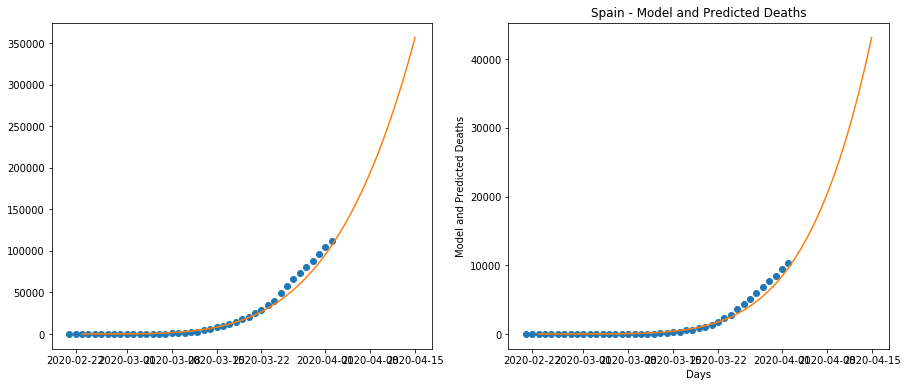

In [73]:
#Model for cases in US
spain_case_parameters = regression_model('Spain','Country/Region','Total Confirmed Cases', spain_consolidated_cases_df, 0)

#rerun model to predict for dates March 30 - April 29. I'm doing this by running the model for an extra month.
x_time_predict = np.arange(1, len(date_list_predicted)+1, 1)
y_predict_cases_spain = concentration_equation(x_time_predict, spain_case_parameters[0], spain_case_parameters[1])

#Model for deaths in US
spain_death_parameters = regression_model('Spain','Country/Region','Total Deaths', spain_consolidated_cases_df, 0)

#rerun model to predict for dates March 30 - April 29. I'm doing this by running the model for an extra month.
x_time_predict = np.arange(1, len(date_list_predicted)+1, 1)
y_predict_deaths_spain = concentration_equation(x_time_predict, spain_death_parameters[0], spain_death_parameters[1])

#Create plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(spain_consolidated_cases_df.loc['Spain'].index, spain_consolidated_cases_df['Total Confirmed Cases'],'o')
ax1.plot(date_list_predicted, y_predict_cases_spain )
plt.xlabel('Days')
plt.ylabel('Model and Predicted Cases')
plt.title('Spain - Model and Predicted Cases')

ax2.plot(spain_consolidated_cases_df.loc['Spain'].index, spain_consolidated_cases_df['Total Deaths'],'o')
ax2.plot(date_list_predicted, y_predict_deaths_spain )         
plt.xlabel('Days')
plt.ylabel('Model and Predicted Deaths')
plt.title('Spain - Model and Predicted Deaths')         

### South Korea Model

In [51]:
southkorea_consolidated_cases_df = country_consolidated_df.copy()

parameters = regression_model('Korea, South','Country/Region','Total Confirmed Cases', southkorea_consolidated_cases_df, 30)


C:\Users\Raili\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in double_scalars



In [52]:
southkorea_consolidated_deaths_df = country_consolidated_df.copy()

parameters = regression_model('Korea, South','Country/Region','Total Deaths', southkorea_consolidated_deaths_df, 30)


C:\Users\Raili\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in double_scalars



### New York Model and Prediction

In [53]:
ny_consolidated_cases_df = state_consolidated_df.groupby('Province/State')
ny_consolidated_cases_df = ny_consolidated_cases_df.get_group('New York')
ny_consolidated_cases_df =  ny_consolidated_cases_df[(ny_consolidated_cases_df.loc['New York'].index > '2020-03-7') & (ny_consolidated_cases_df.loc['New York'].index <= '2020-04-07')]


#date_list = country_consolidated_df.loc['US'].index

ny_consolidated_cases_df

Total Confirmed Cases  Total Deaths  \
Province/State Date                                              
New York       2020-03-08                      0             0   
               2020-03-09                      0             0   
               2020-03-10                    173             0   
               2020-03-11                    220             0   
               2020-03-12                    328             0   
               2020-03-13                    421             0   
               2020-03-14                    525             2   
               2020-03-15                    732             3   
               2020-03-16                    967            10   
               2020-03-17                   1706            13   
               2020-03-18                   2495            16   
               2020-03-19                   5365            34   
               2020-03-20                   8310            42   
               2020-03-21                  11710            60   
               2020-03-22                  15793           117   
               2020-03-23                  20884           158   
               2020-03-24                  25681           210   
               2020-03-25                  30841           285   
               2020-03-26                  37877           385   
               2020-03-27                  44876           527   
               2020-03-28                  52410           728   
               2020-03-29                  59648           965   
               2020-03-30                  66663          1218   
               2020-03-31                  75833          1550   
               2020-04-01                  83948          1941   
               2020-04-02                  92506          2373   
               2020-04-03                 102987          2935   
               2020-04-04                 113833          3565   
               2020-04-05                 123160          4159   
               2020-04-06                 131815          4698   
               2020-04-07                 139875          5489   

                           Total Recoveries  Daily New Cases  \
Province/State Date                                            
New York       2020-03-08                 0              0.0   
               2020-03-09                 0              0.0   
               2020-03-10                 0            173.0   
               2020-03-11                 0             47.0   
               2020-03-12                 0            108.0   
               2020-03-13                 0             93.0   
               2020-03-14                 0            104.0   
               2020-03-15                 0            207.0   
               2020-03-16                 0            235.0   
               2020-03-17                 0            739.0   
               2020-03-18                 0            789.0   
               2020-03-19                 0           2870.0   
               2020-03-20                 0           2945.0   
               2020-03-21                 0           3400.0   
               2020-03-22                 0           4083.0   
               2020-03-23                 0           5091.0   
               2020-03-24                 0           4797.0   
               2020-03-25                 0           5160.0   
               2020-03-26                 0           7036.0   
               2020-03-27                 0           6999.0   
               2020-03-28                 0           7534.0   
               2020-03-29                 0           7238.0   
               2020-03-30                 0           7015.0   
               2020-03-31                 0           9170.0   
               2020-04-01                 0           8115.0   
               2020-04-02                 0           8558.0   
               2020-04-03                 0          104

In [54]:
date_list_predicted = pd.date_range(start="2020-03-09", end="2020-04-15")
len(date_list_predicted)

38

C:\Users\Raili\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in power



Text(0.5, 1.0, 'New York - Model and Predicted Deaths')

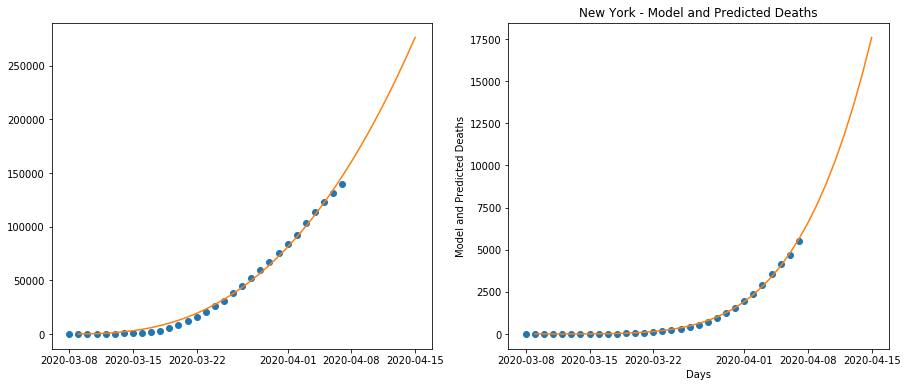

In [55]:
#Model for cases in US
ny_case_parameters = regression_model('New York','Province/State','Total Confirmed Cases', ny_consolidated_cases_df, 0)

#rerun model to predict for dates March 30 - April 29. I'm doing this by running the model for an extra month.
x_time_predict = np.arange(1, len(date_list_predicted)+1, 1)
y_predict_cases_ny = concentration_equation(x_time_predict, ny_case_parameters[0], ny_case_parameters[1])

#Model for deaths in US
ny_death_parameters = regression_model('New York','Province/State','Total Deaths', ny_consolidated_cases_df, 0)

#rerun model to predict for dates March 30 - April 29. I'm doing this by running the model for an extra month.
x_time_predict = np.arange(1, len(date_list_predicted)+1, 1)
y_predict_deaths_ny = concentration_equation(x_time_predict, ny_death_parameters[0], ny_death_parameters[1])

#Create plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(ny_consolidated_cases_df.loc['New York'].index, ny_consolidated_cases_df['Total Confirmed Cases'],'o')
ax1.plot(date_list_predicted, y_predict_cases_ny )
plt.xlabel('Days')
plt.ylabel('Model and Predicted Cases')
plt.title('New York - Model and Predicted Cases')

ax2.plot(ny_consolidated_cases_df.loc['New York'].index, ny_consolidated_cases_df['Total Deaths'],'o')
ax2.plot(date_list_predicted, y_predict_deaths_ny )         
plt.xlabel('Days')
plt.ylabel('Model and Predicted Deaths')
plt.title('New York - Model and Predicted Deaths')         